#### Using OpenCV for data augmentation
Applying a random transformation matrix to the image and the mask.
Combining the mask with a random background.

In [5]:
% matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [6]:
background_dir = "/Datasets/open-images/validation/"
background_imgs = [background_dir + f for f in os.listdir(background_dir)]
num_background_imgs = len(background_imgs)
print(num_background_imgs)

41620


In [84]:
def scale_rotate_translate_img(img, angle=0, scale=1.0, tx=0, ty=0):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # cálculo de la matriz de transformación
    M = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    T = [[0, 0, tx],[0, 0, ty]]
    return cv2.warpAffine(img, M + T, (w, h))

def combine_img_mask_bk(img, mask, bk, focus_blur_kernel=(0,0)):
    if img.shape[:2] != mask.shape[:2] or mask.shape[:2] != bk.shape[:2]:
        raise Exception("images must have the same size to combine them")
    
    # filtro para emular el fuera de foco de la cámara
    bk = cv2.GaussianBlur(bk, focus_blur_kernel, 0)
    
    # https://stackoverflow.com/a/38516107/2692914
    fg_masked = cv2.bitwise_and(img, img, mask=mask)
    mask_neg = cv2.bitwise_not(mask)
    bk_masked = cv2.bitwise_and(bk, bk, mask=mask_neg)
    return cv2.bitwise_or(fg_masked, bk_masked)

def combine_with_border(palm_path, mask_path, bk_path, angle_deg=0, scale=1.0, tx=0, ty=0, focus_blur_kernel=(0, 0)):
    """
    combinar imágenes con borde "suavizado"
    """
    palm = cv2.imread(palm_path)
    palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # erosionar máscara para eliminar los píxeles blancos en los bordes
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

    bk = cv2.imread(bk_path)
    bk = cv2.cvtColor(bk, cv2.COLOR_BGR2RGB)
    bk = cv2.resize(bk, (palm.shape[1],palm.shape[0]))
    
#     return combine_img(palm, mask, bk, angle_deg, scale, tx, ty, focus_blur_kernel)
#     return combine_img2(palm, mask, bk, angle_deg, scale, tx, ty, focus_blur_kernel)
    return combine_img3(palm, mask, bk, angle_deg, scale, tx, ty, focus_blur_kernel)

# def combine(palm_path, mask_path, bk_path, angle_deg=0, scale=1.0, tx=0, ty=0, focus_blur_kernel=(0, 0)):
#     palm = cv2.imread(palm_path)
#     palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

#     mask = cv2.imread(mask_path)
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     # erosionar máscara para eliminar los píxeles blancos en los bordes
#     mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

#     bk = cv2.imread(bk_path)
#     bk = cv2.cvtColor(bk, cv2.COLOR_BGR2RGB)
#     bk = cv2.resize(bk, (palm.shape[1],palm.shape[0]))
    
#     return combine_img_mask_bk(palm, mask, bk, focus_blur_kernel)


def combine_img(palm, mask, bk, angle_deg=0, scale=1.0, tx=0, ty=0, focus_blur_kernel=(0, 0)):
    if scale<0.75 or scale >3.0:
        raise Exception("illegal scale")

    # print("angle_deg="+str(angle_deg)+" scale="+str(scale)+" tx="+str(tx)+" ty="+str(ty)+" focus_blur_kernel="+str(focus_blur_kernel))
    print("angle_deg={:.2f} scale={:.2f} tx={:.0f} ty={:.0f} focus_blur_kernel={}".format(angle_deg,scale,tx,ty,focus_blur_kernel))

    palm = scale_rotate_translate_img(palm, angle_deg, scale, tx, ty)
    mask = scale_rotate_translate_img(mask, angle_deg, scale, tx, ty)

    # borde de combinación a ser suavizado
    border_size_unit = 4
    border_size = (np.uint8(border_size_unit*scale), np.uint8(border_size_unit*scale))
    borders = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, border_size))
    # kernel de suavización debe ser impar
    kernel = (np.uint8(border_size_unit*scale/2)*2+1, np.uint8(border_size_unit*scale/2)*2+1)
    # borders = cv2.blur(borders, kernel)
    borders = cv2.GaussianBlur(borders, kernel, 0)
    # convertimos a 3-canales ya que las operaciones morfológicas trabajan en 1-canal
    borders3c = np.zeros(palm.shape)
    borders3c[:,:,0] = borders
    borders3c[:,:,1] = borders
    borders3c[:,:,2] = borders
    borders3c = borders3c.astype(np.uint8)

    # combinamos
    combined = combine_img_mask_bk(palm, mask, bk, focus_blur_kernel)
    # suavizamos borde de combinación
    combined = cv2.addWeighted(combined, 1.0, borders3c, 0.25, 0)
    return combined

def combine_img2(palm, mask, bk, angle_deg=0, scale=1.0, tx=0, ty=0, focus_blur_kernel=(0, 0)):
    if scale<0.75 or scale >3.0:
        raise Exception("illegal scale")

    # print("angle_deg="+str(angle_deg)+" scale="+str(scale)+" tx="+str(tx)+" ty="+str(ty)+" focus_blur_kernel="+str(focus_blur_kernel))
    print("angle_deg={:.2f} scale={:.2f} tx={:.0f} ty={:.0f} focus_blur_kernel={}".format(angle_deg,scale,tx,ty,focus_blur_kernel))

    palm = scale_rotate_translate_img(palm, angle_deg, scale, tx, ty)
    mask = scale_rotate_translate_img(mask, angle_deg, scale, tx, ty)

    # borde de combinación a ser suavizado
    border_size_unit = 5
    border_size = (np.uint8(border_size_unit*scale), np.uint8(border_size_unit*scale))
    borders = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, border_size))
    # kernel de suavización debe ser impar
    kernel = (np.uint8(border_size_unit*scale/2)*2+1, np.uint8(border_size_unit*scale/2)*2+1)
    # borders = cv2.blur(borders, kernel)
    borders = cv2.GaussianBlur(borders, kernel, 0)
    # combinación con canal alpha 
    combined = combine_img_mask_bk(palm, mask, bk, focus_blur_kernel)
    combined2 = cv2.GaussianBlur(combined, kernel, 0)
    blended = alpha_blend(combined2, combined, borders)    
    return blended

def combine_img3(palm, mask, bk, angle_deg=0, scale=1.0, tx=0, ty=0, focus_blur_kernel=(0, 0)):
    if scale<0.75 or scale >3.0:
        raise Exception("illegal scale")

    # print("angle_deg="+str(angle_deg)+" scale="+str(scale)+" tx="+str(tx)+" ty="+str(ty)+" focus_blur_kernel="+str(focus_blur_kernel))
    print("angle_deg={:.2f} scale={:.2f} tx={:.0f} ty={:.0f} focus_blur_kernel={}".format(angle_deg,scale,tx,ty,focus_blur_kernel))

    palm = scale_rotate_translate_img(palm, angle_deg, scale, tx, ty)
    mask = scale_rotate_translate_img(mask, angle_deg, scale, tx, ty)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
    border_size_unit = 5
    kernel_mask = (np.uint8(border_size_unit*scale/2)*2+1, np.uint8(border_size_unit*scale/2)*2+1)
    mask = mask.astype(float)
    mask = cv2.GaussianBlur(mask, kernel_mask, 0)
    mask3c = np.zeros(palm.shape, float)
    mask3c[:,:,0] = mask
    mask3c[:,:,1] = mask
    mask3c[:,:,2] = mask
    
    # alpha blending:
    palm = palm.astype(float)
    bk = bk.astype(float)
    mask3c = mask3c.astype(float)/255
    # Multiply the foreground with the alpha matte
    palm = cv2.multiply(mask3c, palm)
     # Multiply the background with ( 1 - alpha )
    bk = cv2.multiply(1.0 - mask3c, bk)
    # Add the masked foreground and background.
    combined = cv2.add(palm, bk) 
    return combined

def alpha_blend(img1, img2, mask): 
    """
    alpha blending 
    """
    if img1.shape[:2] != img2.shape[:2] or img2.shape[:2] != mask.shape[:2]:
        raise Exception("input images for alpha_blend must have the same size")
    
    blended = np.zeros(img1.shape)
    for i in range(0, blended.shape[0]):
        for j in range(0, blended.shape[1]):
            alpha = mask[i,j]/255.0;
            blended[i,j] = alpha*img1[i,j] + (1-alpha)*img2[i,j]
    return blended.astype(np.uint8)

In [85]:
import csv

bk_dir = "/Datasets/open-images/validation/"
bk_paths = [bk_dir + f for f in os.listdir(bk_dir)]

palm_dir = "/Datasets/5k-palms/5k-palms/"
palm_paths = [palm_dir + f for f in os.listdir(palm_dir)]
palm_paths.sort()

mask_dir = "/Datasets/5k-palms/5k-palms-masks/"
mask_paths = [mask_dir + f for f in os.listdir(mask_dir)]
mask_paths.sort()

dataset_dir = "/Datasets/5k-palms/40k/"
with open(dataset_dir + "dataset.csv", "w") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    # for p in range(0, len(palm_paths)):
    for p in range(0, 1):
        palm_path = palm_paths[p]
        mask_path = mask_paths[p]

        palm = cv2.imread(palm_path)
        palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # erosionar máscara para eliminar los píxeles blancos en los bordes
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

        num_samples_per_image = 8
        for i in range(0, num_samples_per_image):
            bk_img_num = np.uint8(np.random.uniform(0, len(background_imgs)))
            bk_path = background_imgs[bk_img_num]
            print(bk_path)
            bk = cv2.imread(bk_path)
            bk = cv2.cvtColor(bk, cv2.COLOR_BGR2RGB)
            bk = cv2.resize(bk, (palm.shape[1],palm.shape[0]))

            angle = np.random.uniform(-180, 180)
            scale = np.random.uniform(1.5, 3.0)
            tx = np.random.uniform(-palm.shape[1]//(3*scale), palm.shape[1]//(3*scale))  # sólo mover la tercera parte
            ty = np.random.uniform(-palm.shape[0]//(3*scale), palm.shape[0]//(3*scale))  # sólo mover la tercera parte
            focus_blur_size = np.uint8(np.random.uniform(0, 7))*2+1
            combined = combine_with_border(palm_path, mask_path, bk_path, angle, scale, tx, ty, (focus_blur_size,focus_blur_size))
            combined = combined.astype(np.uint8)
            
            combined_path = dataset_dir + os.path.basename(palm_path) +"."+str(i)+".png"
            cv2.imwrite(combined_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
            csv_writer.writerow([combined_path, palm_path, mask_path, bk_path, angle, scale, tx, ty, focus_blur_size])
            
    print(csv_file, " written")

/Datasets/open-images/validation/bc31189f3656ff4a.jpg
angle_deg=76.02 scale=2.49 tx=96 ty=14 focus_blur_kernel=(7, 7)
/Datasets/open-images/validation/347d6c8639a1bb09.jpg
angle_deg=17.32 scale=2.59 tx=44 ty=43 focus_blur_kernel=(13, 13)
/Datasets/open-images/validation/c75dc9a0a71f5bf5.jpg
angle_deg=-51.37 scale=2.19 tx=64 ty=-0 focus_blur_kernel=(11, 11)
/Datasets/open-images/validation/be462ea9c5abc09f.jpg
angle_deg=114.02 scale=2.10 tx=-94 ty=-21 focus_blur_kernel=(5, 5)
/Datasets/open-images/validation/9635278c951776ee.jpg
angle_deg=-140.47 scale=2.87 tx=10 ty=-13 focus_blur_kernel=(13, 13)
/Datasets/open-images/validation/61e5a9ac02d31d84.jpg
angle_deg=145.84 scale=2.06 tx=-42 ty=-24 focus_blur_kernel=(1, 1)
/Datasets/open-images/validation/a65e9ea046327e8c.jpg
angle_deg=178.94 scale=2.93 tx=48 ty=17 focus_blur_kernel=(11, 11)
/Datasets/open-images/validation/f811d03b84214789.jpg
angle_deg=-18.04 scale=2.98 tx=-60 ty=64 focus_blur_kernel=(1, 1)
<_io.TextIOWrapper name='/Datasets/

Generando n imágenes por palma 

/Datasets/open-images/validation/b5083b48e7198332.jpg
angle_deg=40.64 scale=2.98 tx=14 ty=-24 focus_blur_kernel=(7, 7)


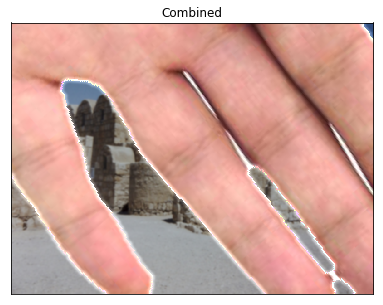

/Datasets/open-images/validation/f22941a408c9f580.jpg
angle_deg=-1.43 scale=2.26 tx=-75 ty=-30 focus_blur_kernel=(13, 13)


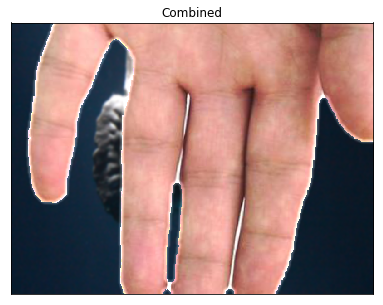

/Datasets/open-images/validation/eeba4dab4ff7aa27.jpg
angle_deg=-118.64 scale=2.25 tx=-81 ty=-84 focus_blur_kernel=(5, 5)


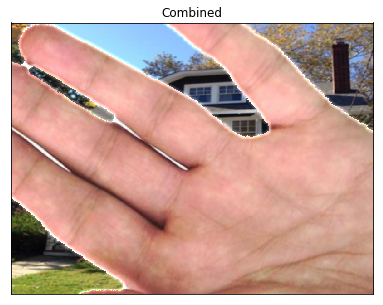

/Datasets/open-images/validation/0b07cb2f8452e2eb.jpg
angle_deg=37.67 scale=1.68 tx=-19 ty=-51 focus_blur_kernel=(13, 13)


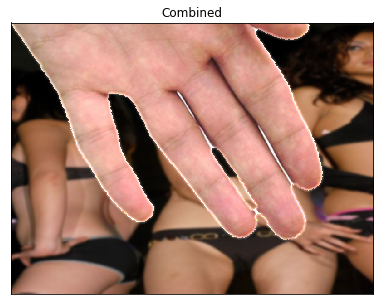

/Datasets/open-images/validation/a8ef3ae2c618e2ae.jpg
angle_deg=-101.27 scale=2.25 tx=86 ty=67 focus_blur_kernel=(9, 9)


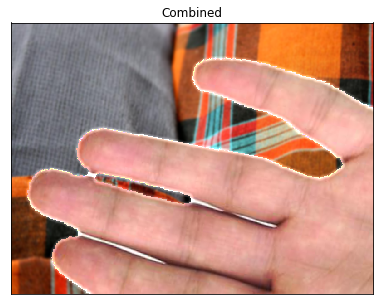

/Datasets/open-images/validation/d89e123ddd967671.jpg
angle_deg=-157.50 scale=1.68 tx=-72 ty=-13 focus_blur_kernel=(11, 11)


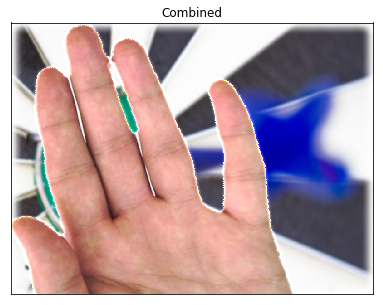

/Datasets/open-images/validation/9635278c951776ee.jpg
angle_deg=-57.10 scale=1.63 tx=-127 ty=8 focus_blur_kernel=(11, 11)


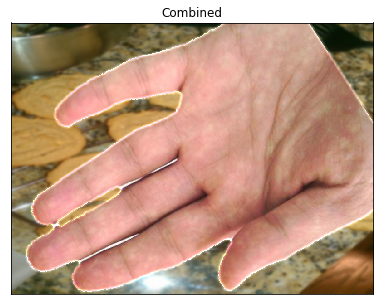

/Datasets/open-images/validation/f8234574d2285fbc.jpg
angle_deg=-46.63 scale=2.09 tx=65 ty=25 focus_blur_kernel=(1, 1)


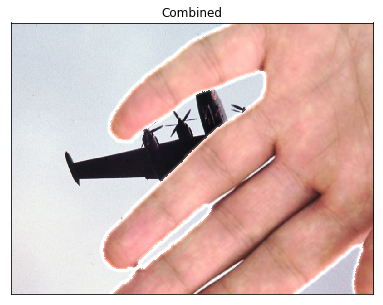

In [178]:
# 5388 palm images
# 41620 background images
palm_path = "/Datasets/5k-palms/5k-palms/Hand_0000988.jpg"
mask_path = "/Datasets/5k-palms/5k-palms-masks/Hand_0000988.jpg.png"

palm = cv2.imread(palm_path)
palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# erosionar máscara para eliminar los píxeles blancos en los bordes
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

for i in range(0, 8):
    bk_img_num = np.uint8(np.random.uniform(0, len(background_imgs)))
    bk_path = background_imgs[bk_img_num]
    print(bk_path)
    bk = cv2.imread(bk_path)
    bk = cv2.cvtColor(bk, cv2.COLOR_BGR2RGB)
    bk = cv2.resize(bk, (palm.shape[1],palm.shape[0]))

    angle = np.random.uniform(-180, 180)
    scale = np.random.uniform(1.5, 3.0)
    tx = np.random.uniform(-palm.shape[1]//(3*scale), palm.shape[1]//(3*scale))  # sólo mover la tercera parte
    ty = np.random.uniform(-palm.shape[0]//(3*scale), palm.shape[0]//(3*scale))  # sólo mover la tercera parte
    focus_blur_size = np.uint8(np.random.uniform(0, 7))*2+1
    combined = combine(palm_path, mask_path, bk_path, angle, scale, tx, ty, (focus_blur_size,focus_blur_size))

    plt.figure(figsize=(15, 5))

    plt.imshow(combined)
    plt.title("Combined")
    plt.xticks([])
    plt.yticks([])

    plt.show()

Imagen combinada sin "suavizamiento" de bordes

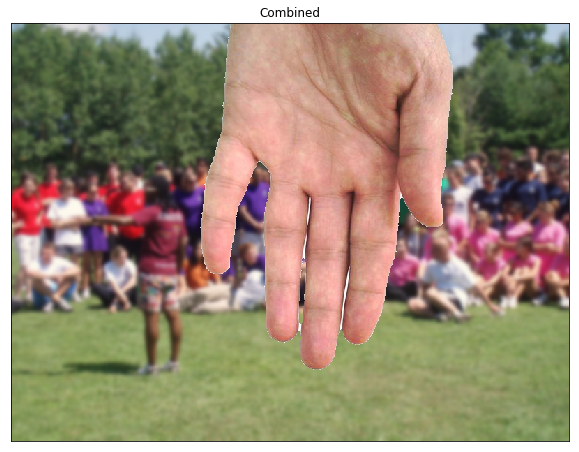

In [59]:
palm_path = "/Datasets/5k-palms/5k-palms/Hand_0000988.jpg"
mask_path = "/Datasets/5k-palms/5k-palms-masks/Hand_0000988.jpg.png"
bk_path = "/Datasets/open-images/validation/8788284a8b3aa6c1.jpg"

palm = cv2.imread(palm_path)
palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

bk = cv2.imread(bk_path)
bk = cv2.cvtColor(bk, cv2.COLOR_BGR2RGB)
bk = cv2.resize(bk, (palm.shape[1],palm.shape[0]))

combined = combine(palm, mask, bk)


# display_num = 1
# plt.figure(figsize=(15, 3))

# plt.subplot(display_num, 3, 0 + 1)
# plt.imshow(palm)
# plt.title("Palm")
# plt.xticks([])
# plt.yticks([])

# plt.subplot(display_num, 3, 0 + 2)
# plt.imshow(mask, cmap='gray')
# plt.title("Mask")  
# plt.xticks([])
# plt.yticks([])

# plt.subplot(display_num, 3, 0 + 3)
# plt.imshow(bk)
# plt.title("Background")  
# plt.xticks([])
# plt.yticks([])

# plt.show()

plt.figure(figsize=(10, 10))

plt.imshow(combined)
plt.title("Combined")  
plt.xticks([])
plt.yticks([])

plt.show()

In [22]:
def flip_img(img, flip_code = 1):
    """
    Aumentación de datos: voltear la imagen según flip_code
    0: horizontal 
    1: vertical
    -1: both
    """
    out = np.zeros(img.shape, np.uint8)  # out = img.copy()
    out = cv2.flip(img, flip_code)  
    return out


In [60]:
def rotate_img(img, angle):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def rotate_translate_img(img, angle, tx=0, ty=0):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    T = [[0, 0, tx],[0, 0, ty]]
    return cv2.warpAffine(img, M + T, (w, h))

def scale_rotate_translate_img(img, angle, scale=1.0, tx=0, ty=0):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # cálculo de la matriz de transformación
    M = cv2.getRotationMatrix2D((cX, cY), angle, scale)
    T = [[0, 0, tx],[0, 0, ty]]
    return cv2.warpAffine(img, M + T, (w, h))

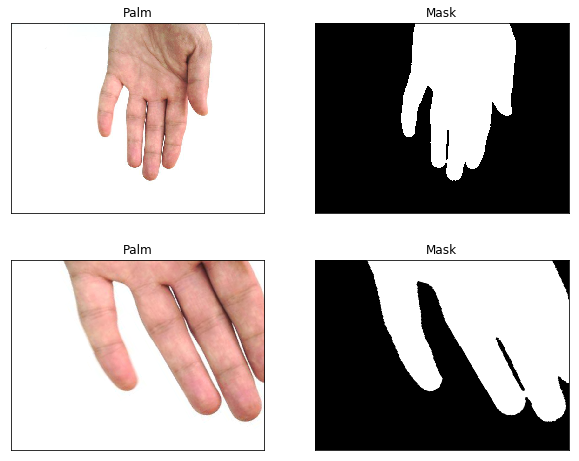

In [60]:
palm_path = "/Datasets/5k-palms/5k-palms/Hand_0000988.jpg"
mask_path = "/Datasets/5k-palms/5k-palms-masks/Hand_0000988.jpg.png"

palm = cv2.imread(palm_path)
palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

palm_aug = scale_rotate_translate_img(palm, 30, 2.0, 100, -100)
mask_aug = scale_rotate_translate_img(mask, 30, 2.0, 100, -100)

plt.figure(figsize=(10, 8))

display_num = 2

palms = [palm, palm_aug]
masks = [mask, mask_aug]
for i in range(0, display_num*2, 2):
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(palms[i//2])
    plt.title("Palm")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(masks[i//2], cmap='gray')
    plt.title("Mask")  
    plt.xticks([])
    plt.yticks([])

plt.show()

(480, 864, 3)
(480, 864, 3)


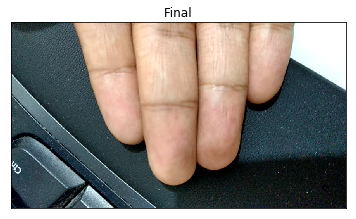

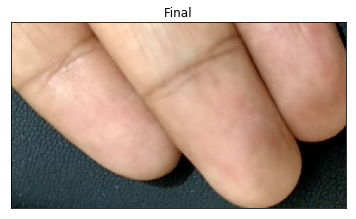

In [47]:
img_path = "/Datasets/handpalm/frames/flash-2018-10-24_23-40-51-25-frame.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # make plt compatible

# out = flip_img(img)
# out = rotate_img(img, 30)
out = scale_rotate_translate_img(img, 30, 2.0, 100, -100)

plt.title('Final'), plt.xticks([]), plt.yticks([])
plt.imshow(img)
plt.show()

plt.title('Final'), plt.xticks([]), plt.yticks([])
plt.imshow(out)
plt.show()

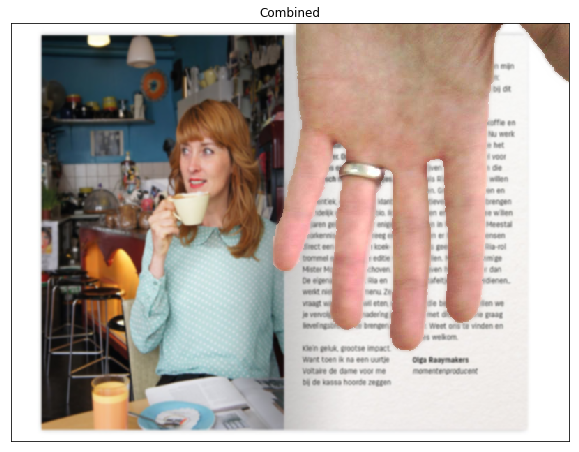

In [52]:
##### TO DELETE
palm_path = "/Datasets/5k-palms/40k/Hand_0000038.jpg.2.png"
mask_path = "/Datasets/5k-palms/5k-palms-masks/Hand_0000038.jpg.png"

palm = cv2.imread(palm_path)
palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

border_size = 5
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# erosionar máscara para eliminar los píxeles blancos en los bordes
# mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))
mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (border_size,border_size)))
mask = cv2.GaussianBlur(mask, (border_size*3,border_size*3), 0)
mask = mask.astype(np.uint8)

palm2 = cv2.GaussianBlur(palm, (border_size*3,border_size*3), 0)

blended = alpha_blend(palm, palm2, 255-mask)

plt.figure(figsize=(10, 10))

plt.imshow(blended)
plt.title("Combined")  
plt.xticks([])
plt.yticks([])

plt.show()